# An Introduction to Algorithms using Qiskit

This introduction to algorithms using Qiskit provides a high-level overview to get started with the `qiskit_algorithms` library.

## How is the algorithm library structured?

`qiskit_algorithms` provides a number of [algorithms](https://qiskit-community.github.io/qiskit-algorithms/apidocs/algorithms.html) grouped by category, according to the task they can perform. For instance `Minimum Eigensolvers` to find the smallest eigen value of an operator, for example ground state energy of a chemistry Hamiltonian or a solution to an optimization problem when expressed as an Ising Hamiltonian. There are `Time Evolvers` for the time evolution of quantum systems and `Amplitude Estimators` for value estimation that can be used say in financial applications. The full set of categories can be seen in the documentation link above.

Algorithms are configurable, and part of the configuration will often be in the form of smaller building blocks. For instance `VQE`, the Variational Quantum Eigensolver, it takes a trial wavefunction, in the form of a `QuantumCircuit` and a classical optimizer among other things.

Let's take a look at an example to construct a VQE instance. Here, `n_local` is the variational form (trial wavefunction), a parameterized circuit which can be varied, and `SLSQP` a classical optimizer. These are created as separate instances and passed to VQE when it is constructed. Trying, for example, a different classical optimizer, or variational form is simply a case of creating an instance of the one you want and passing it into VQE.

In [1]:
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import n_local

num_qubits = 2
ansatz = n_local(num_qubits, "ry", "cz")
optimizer = SLSQP(maxiter=1000)

Let's draw the ansatz so we can see it's a `QuantumCircuit` where θ\[0\] through θ\[7\] will be the parameters that are varied as VQE optimizer finds the minimum eigenvalue. We'll come back to the parameters later in a working example below.

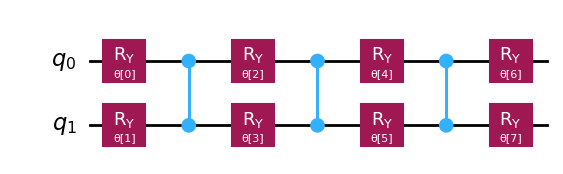

In [2]:
ansatz.draw("mpl")

But more is needed before we can run the algorithm so let's get to that next.

## How to run an algorithm?

Algorithms rely on the primitives to evaluate expectation values or sample circuits. The primitives can be based on a simulator or real device and can be used interchangeably in the algorithms, as they all implement the same interface.

In the VQE, we have to evaluate expectation values, so for example we can use the [qiskit.primitives.StatevectorEstimator](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.primitives.StatevectorEstimator) which is shipped with the default Qiskit installation.

In [3]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

This estimator uses an exact, statevector simulation to evaluate the expectation values. We can also use a noisy simulator or real backends instead. For more information of the simulators you can check out [Qiskit Aer](https://qiskit.github.io/qiskit-aer/apidocs/aer_primitives.html) and for the actual hardware [Qiskit IBM Runtime](https://quantum.cloud.ibm.com/docs/api/qiskit-ibm-runtime).

With all the ingredients ready, we can now instantiate the VQE:

In [4]:
from qiskit_algorithms import VQE

vqe = VQE(estimator, ansatz, optimizer)

Now we can call the [compute_mininum_eigenvalue()](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html#qiskit_algorithms.VQE.compute_minimum_eigenvalue) method. The latter is the interface of choice for the application modules, such as Nature and Optimization, in order that they can work interchangeably with any algorithm within the specific category.

## A complete working example

Let's put what we have learned from above together and create a complete working example. VQE will find the minimum eigenvalue, i.e. minimum energy value of a Hamiltonian operator and hence we need such an operator for VQE to work with. Such an operator is given below. This was originally created by the Nature application module as the Hamiltonian for an H2 molecule at 0.735A interatomic distance. It's a sum of Pauli terms as below.

In [5]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

So let's run VQE and print the result object it returns.

In [6]:
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 56,
    'eigenvalue': np.float64(-1.8572750043551267),
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f9de46c0c90>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): np.float64(3.8216810016823652),
                              ParameterVectorElement(θ[1]): np.float64(-6.310507271097852),
                              ParameterVectorElement(θ[2]): np.float64(2.761245969250949),
                              ParameterVectorElement(θ[3]): np.float64(2.4401140923202016),
                              ParameterVectorElement(θ[4]): np.float64(2.833791885749139),
                              ParameterVectorElement(θ[5]): np.float64(-5.526380711861978),
                              ParameterVectorElement(θ[6]): np.float64(-0.5241844512608815),
                              ParameterVectorElement(θ[7]): np.float64(3.128832883826076)},
    'optimal_point': array([ 3.821681  , -6.310507

From the above result we can see the number of cost function (=energy) evaluations the optimizer took until it found the minimum eigenvalue of $\approx -1.85727$ which is the electronic ground state energy of the given H2 molecule. The optimal parameters of the ansatz can also be seen which are the values that were in the ansatz at the minimum value.

## Updating the primitive inside VQE

Let's also change the estimator primitive inside the a VQE. Maybe you're satisfied with the simulation results and now want to use a noisy simulator, or run on hardware!

In this example we're changing to a noisy estimator, still using Qiskit's reference primitive. However, you could replace the primitive by e.g. Qiskit Aer's estimator ([qiskit_aer.primitives.EstimatorV2](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.primitives.EstimatorV2.html#qiskit_aer.primitives.EstimatorV2)) or even a real backend ([qiskit_ibm_runtime.EstimatorV2](https://quantum.cloud.ibm.com/docs/api/qiskit-ibm-runtime/estimator-v2)).

For noisy loss functions, the SPSA optimizer typically performs well, so we also update the optimizer. See also the [noisy VQE tutorial](03_vqe_simulation_with_noise.ipynb) for more details on shot-based and noisy simulations.

In [7]:
from qiskit_algorithms.optimizers import SPSA

estimator = StatevectorEstimator(default_precision=1e-2)

vqe.estimator = estimator
vqe.optimizer = SPSA(maxiter=100)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': np.float64(-1.8642631852005251),
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f9de46c3cb0>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): np.float64(3.18874102257752),
                              ParameterVectorElement(θ[1]): np.float64(4.44525009783019),
                              ParameterVectorElement(θ[2]): np.float64(-5.432050386217793),
                              ParameterVectorElement(θ[3]): np.float64(2.9633312549903157),
                              ParameterVectorElement(θ[4]): np.float64(-3.3561398735861885),
                              ParameterVectorElement(θ[5]): np.float64(-2.4499114699188227),
                              ParameterVectorElement(θ[6]): np.float64(-2.3107200250466),
                              ParameterVectorElement(θ[7]): np.float64(1.2611466356539753)},
    'optimal_point': array([ 3.18874102,  4.4452501

Note: We do not fix the random seed in the simulators here, so re-running gives slightly varying results.

## Transpilation options
To close off, if you want to run on real hardware, you'll be required to transpile your circuits beforehand. In some cases, such as in `VQE`, the circuit is provided by the user, which means that it can be transpiled beforehand. But in other cases, such as in [`Grover`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.Grover.html), the class creates its circuit internally.

To deal with this problem, every user-facing class in `qiskit-algorithms` can be provided with a `transpiler` and a a `transpiler_options` keyword-only arguments. The `transpiler` is any object having a `run` method that is able to transpile a `QuantumCircuit`, while the `transpiler_options` argument is a dictionary of options to be passed to the `transpiler`'s `run` method.

As an example, let us define a custom backend on four qubits. Note that this backend has more qubits than our ansatz and our observable.

In [8]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2

coupling_map = [(0, 1), (1, 2), (2, 3)]
backend = GenericBackendV2(num_qubits=4, coupling_map=coupling_map, seed=54)

Let us define a `PassManager` for this backend.

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

We can then pass this `PassManager` to the `transpiler` keyword argument of the `VQE` constructor. We can also pass any options to the `run` method of the `Transpiler` by setting the `transpiler_options` keyword argument to a dictionary specifying said options. For instance, let us define a `callback` function that prints out that it has been called on the very first step of the transpilation.

In [10]:
def callback(**kwargs):
    if kwargs["count"] == 0:
        print(f"Callback function has been called!")

We can now build a `VQE` instance using this `PassManager` like so.

In [11]:
vqe = VQE(
    estimator, ansatz, SPSA(maxiter=100), transpiler=pm, transpiler_options={"callback": callback}
)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(result)

Callback function has been called!
{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': np.float64(-1.850941224424128),
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f9de4761390>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): np.float64(-5.767339784150907),
                              ParameterVectorElement(θ[1]): np.float64(-3.125873085717741),
                              ParameterVectorElement(θ[2]): np.float64(0.624838684681521),
                              ParameterVectorElement(θ[3]): np.float64(0.2986408161141705),
                              ParameterVectorElement(θ[4]): np.float64(7.011272184157897),
                              ParameterVectorElement(θ[5]): np.float64(0.03033368552671569),
                              ParameterVectorElement(θ[6]): np.float64(-2.5898620839549285),
                              ParameterVectorElement(θ[7]): np.float64(2.863708966610142)},
    'optimal_p

Note that as seen below, the ansatz has automatically been transpiled.

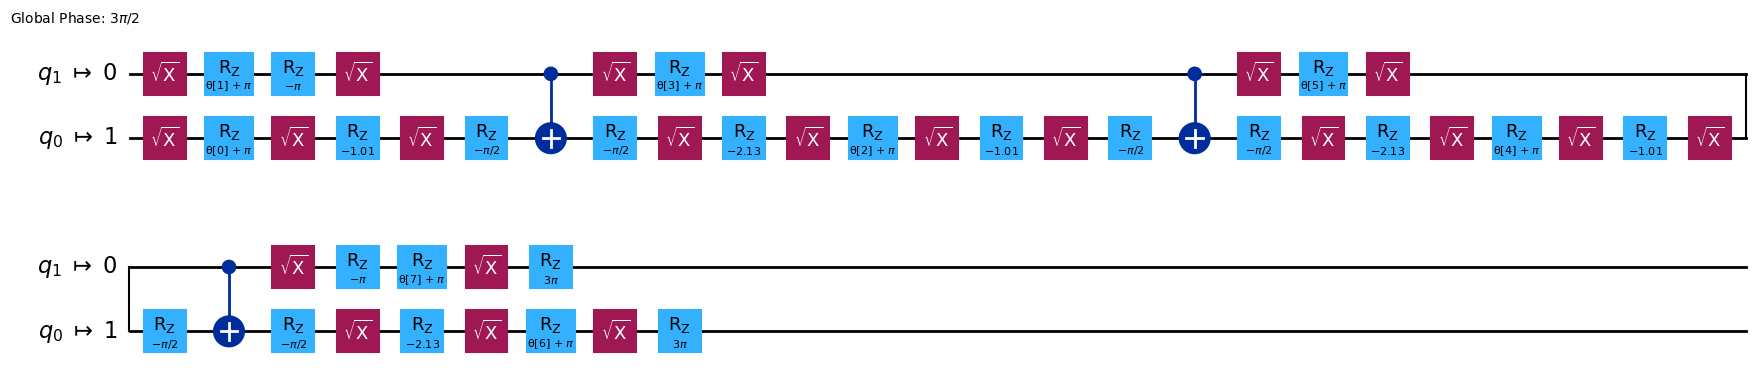

In [12]:
vqe.ansatz.draw("mpl")

This concludes this introduction to algorithms using Qiskit. Please check out the other algorithm tutorials in this series for both broader as well as more in depth coverage of the algorithms.

In [13]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright